In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
from utils.ml_utils import *
from typing import List, Dict
from pyod.models.ecod import ECOD
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest

In [2]:
file_path = "Data/metrics_collector.tsv"

column_names = [
    'account_id', 'name', 'point', 'call_count', 'total_call_time', 
    'total_exclusive_time', 'min_call_time', 'max_call_time', 
    'sum_of_squares', 'instances', 'language', 'app_name', 
    'app_id', 'scope', 'host', 'display_host', 'pid', 
    'agent_version', 'labels'
]

data = pd.read_csv(file_path, sep='\t', header=None)
data.columns = column_names
metrics_table = make_table(data)
metrics_table

/var/folders/n9/qf3jg31d5rz3v4ydwp7__zfm0000gn/T/ipykernel_55375/471163818.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', header=None)
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["point"] = pd.to_datetime(filtered_data["point"])
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,time,time_numeric,web_response,throughput,apdex,error
0,2024-04-15 23:32:00,28553732.0,0.007722,3898.0,0.999679,0.000128
1,2024-04-15 23:33:00,28553733.0,0.008363,3917.5,0.999745,0.000128
2,2024-04-15 23:34:00,28553734.0,0.008709,3993.0,0.999687,0.000000
3,2024-04-15 23:35:00,28553735.0,0.008286,3991.5,0.999812,0.000000
4,2024-04-15 23:36:00,28553736.0,0.010874,3915.5,0.999489,0.000000
...,...,...,...,...,...,...
43267,2024-05-16 00:54:00,28597014.0,0.009245,2560.0,0.998828,0.000000
43268,2024-05-16 00:55:00,28597015.0,0.010571,2491.0,0.998495,0.000000
43269,2024-05-16 00:56:00,28597016.0,0.011785,2429.0,0.997736,0.000206
43270,2024-05-16 00:57:00,28597017.0,0.010940,2373.5,0.997999,0.000211


In [10]:
start_date = pd.to_datetime("2024-04-15 23:32:00")
end_date = pd.to_datetime("2024-05-16 00:58:00")
columns_name = ["web_response", "throughput"]
result = ml(metrics_table, start_date, end_date, columns_name)
result

{'web_response':        labels  probability                time     value
 0           0     0.314801 2024-04-15 23:32:00  0.007722
 1           0     0.306986 2024-04-15 23:33:00  0.008363
 2           0     0.307901 2024-04-15 23:34:00  0.008709
 3           0     0.305502 2024-04-15 23:35:00  0.008286
 4           0     0.318257 2024-04-15 23:36:00  0.010874
 ...       ...          ...                 ...       ...
 43267       0     0.336189 2024-05-16 00:54:00  0.009245
 43268       0     0.334927 2024-05-16 00:55:00  0.010571
 43269       0     0.351911 2024-05-16 00:56:00  0.011785
 43270       0     0.340817 2024-05-16 00:57:00  0.010940
 43271       0     0.369369 2024-05-16 00:58:00  0.007973
 
 [43272 rows x 4 columns],
 'throughput':        labels  probability                time   value
 0           0     0.000000 2024-04-15 23:32:00  3898.0
 1           0     0.000000 2024-04-15 23:33:00  3917.5
 2           0     0.000000 2024-04-15 23:34:00  3993.0
 3           0     0.

In [12]:
result["throughput"]

,labels,probability,time,value
0,0,0.000000,2024-04-15 23:32:00,3898.0
1,0,0.000000,2024-04-15 23:33:00,3917.5
2,0,0.000000,2024-04-15 23:34:00,3993.0
3,0,0.000000,2024-04-15 23:35:00,3991.5
4,0,0.000000,2024-04-15 23:36:00,3915.5
...,...,...,...,...
43267,0,0.552360,2024-05-16 00:54:00,2560.0
43268,0,0.361157,2024-05-16 00:55:00,2491.0
43269,0,0.361157,2024-05-16 00:56:00,2429.0
43270,0,0.361157,2024-05-16 00:57:00,2373.5


In [19]:
def plot_anomalies(data: Dict[str, pd.DataFrame], feature_name : str):
    
    df = data[feature_name]

    plt.figure(figsize=(20, 8))

    plt.plot(df['time'], df['value'], color='blue', label=f'Значения показателя {feature_name}')
    anomalies = df[df['labels'] == 1]
    plt.scatter(anomalies['time'], anomalies['value'], color='red', s=100, label='Аномалия')
    plt.title(f'Временной ряд с аномалиями показателя {feature_name}')
    plt.xlabel('Временной ряд')
    plt.ylabel(f'{feature_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


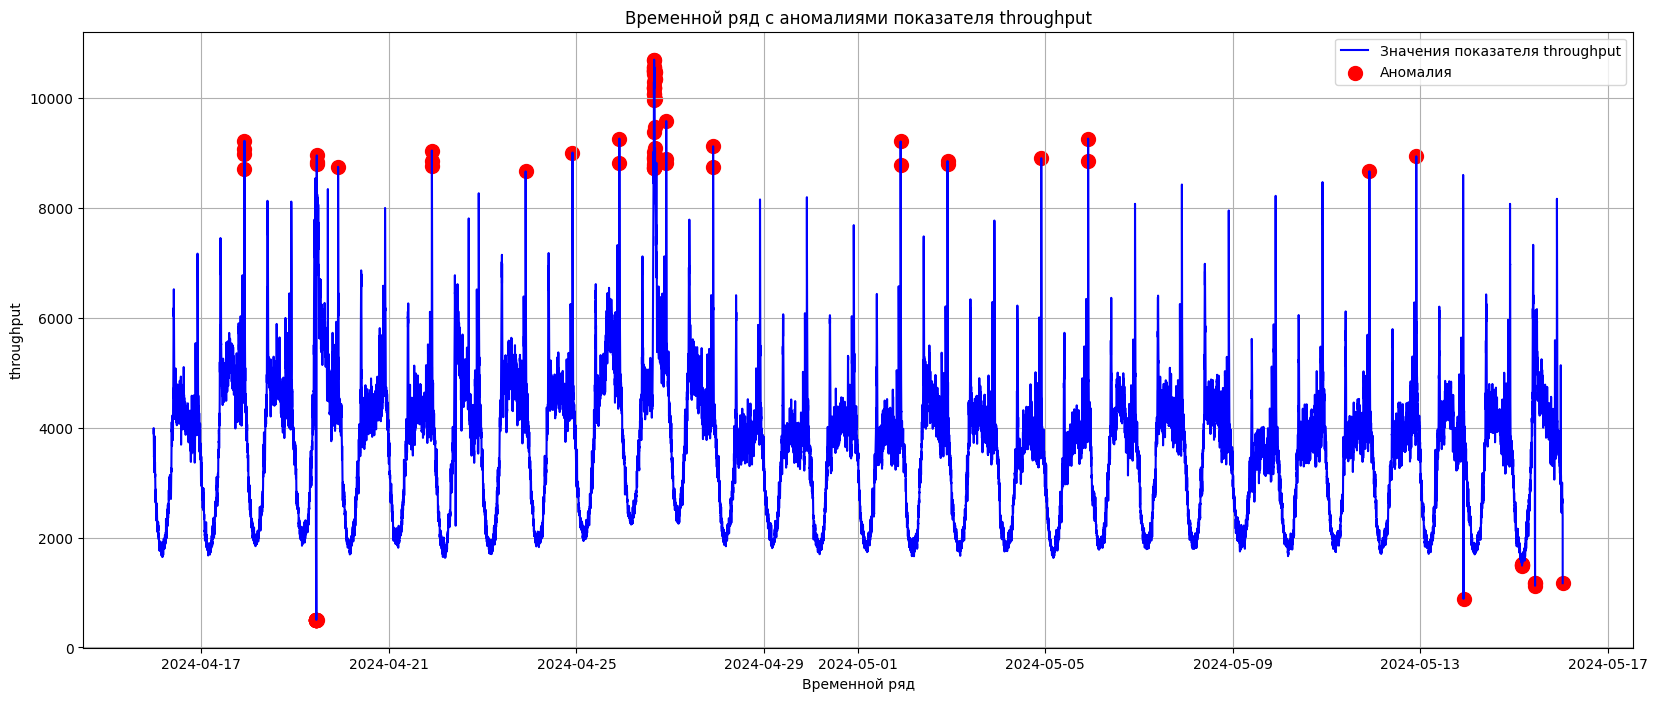

In [20]:
plot_anomalies(result, feature_name = "throughput")

In [ ]:
def plot_anomalies(data, anomaly_mask, value_col):
    
    metrics_table_copy = data.copy()
    metrics_table_copy['anomaly'] = anomaly_mask
    
    plt.figure(figsize=(40, 20))
    plt.plot(metrics_table_copy["time"], metrics_table_copy[value_col], color='blue', label=value_col)
    plt.scatter(metrics_table_copy[metrics_table_copy['anomaly'] == 1]["time"], 
                metrics_table_copy[metrics_table_copy['anomaly'] == 1][value_col], 
                color='red', label='Anomaly', zorder=5)
    plt.title(f'{value_col} with Anomalies')
    plt.xlabel('Time')
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(True)
    plt.show()
